# Data Loading

In [1]:
import pandas as pd
import os

data_dir = "../data"
#Read the data from data folder
user_sample = pd.read_json(os.path.join(data_dir, "user_sample.json"), lines=True)


# **Investigating the Causal Effect of Twitter Subscription Program on User Engagement**

## **Identifying the Problem**  
The objective of this study is to estimate the **causal effect of Twitter subscription eligibility** on users’ **engagement**, specifically their **tweet count**. Eligibility for the subscription program is determined by users’ **follower count**, with those having at least **2000 followers** being eligible for subscriptions, and those with fewer followers not being eligible.

We exploit a **threshold-based assignment** where users with a **follower count of 2000 or more** are eligible for the subscription program, while users with fewer than **2000 followers** are not. This setting allows us to assess whether crossing the **2000 follower cutoff** leads to a discontinuous change in users’ engagement, measured by **tweet count**.

---

## **Defining the Key Variables**

### **A. Running Variable (\(X_i\))**
- The user’s **follower count**.
- Continuous, ranging from **0 to an unlimited number**.

### **B. Cutoff (\(X_i = 2000\))**
- The threshold for subscription eligibility.
- Users with a **follower count of 2000 or more** are considered **eligible for the subscription program** (\(D_i = 1\)), while users with **fewer than 2000 followers** are **ineligible** (\(D_i = 0\)).

### **C. Treatment Indicator (\(D_i\))**
- **\(D_i = 1\)** if \(X_i >= 2000\) (eligible for subscription).
- **\(D_i = 0\)** if \(X_i < 2000\) (ineligible for subscription).

### **D. Outcome Variable (\(Y_i\))**
- The **engagement of the user**, measured by **tweet count**.


In [14]:
import pandas as pd
df = pd.DataFrame()
tweet_count = []
follower_count = []

for index, row in user_sample.iterrows():
    if row['public_metrics']['followers_count'] < 10000:
        follower_count.append(row['public_metrics']['followers_count'])
        tweet_count.append(row['public_metrics']['tweet_count'])

df['follower_count'] = follower_count
df['tweet_count'] = tweet_count

In [15]:
df

,follower_count,tweet_count
0,7316,3098
1,123,1823
2,3,66
3,350,237
4,240,3713
...,...,...
798,1,0
799,22,5
800,589,5219
801,1199,3674


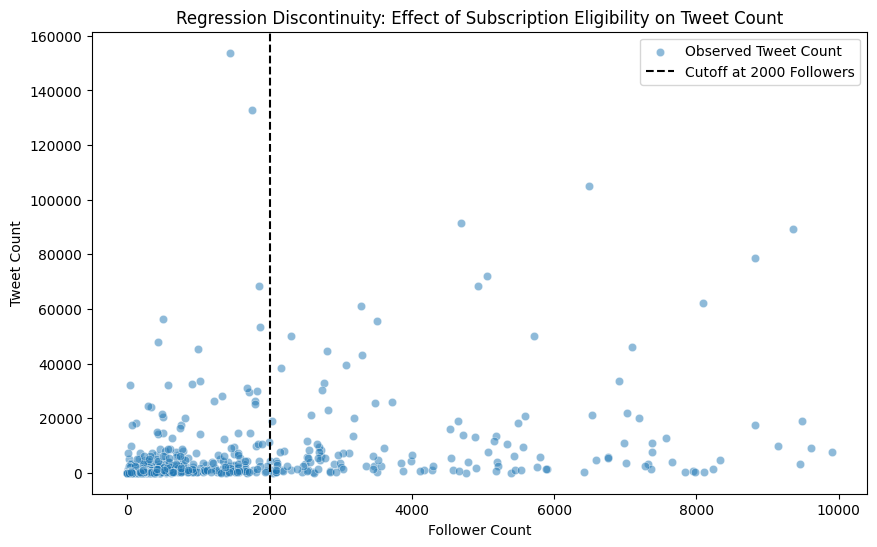

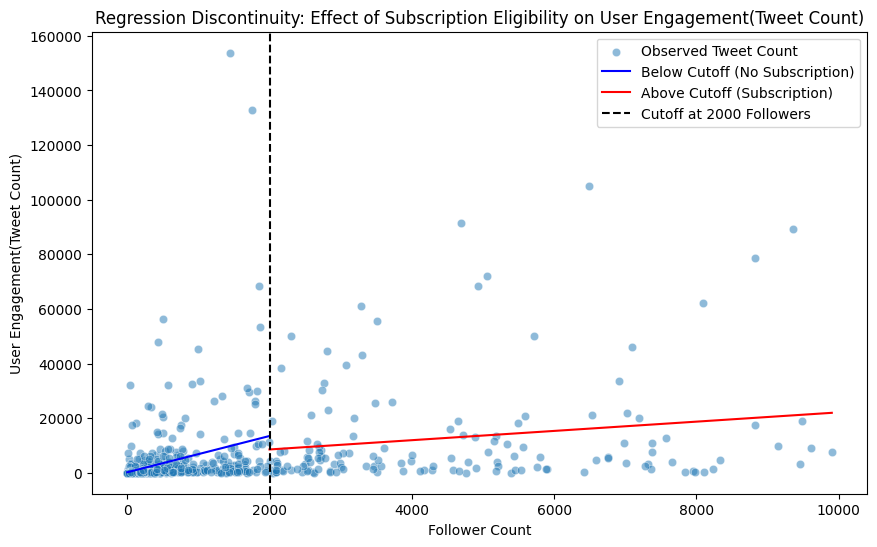


Regression Results:
                            OLS Regression Results                            
Dep. Variable:            tweet_count   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     49.39
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.74e-29
Time:                        20:18:29   Log-Likelihood:                -8686.2
No. Observations:                 803   AIC:                         1.738e+04
Df Residuals:                     799   BIC:                         1.740e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const            

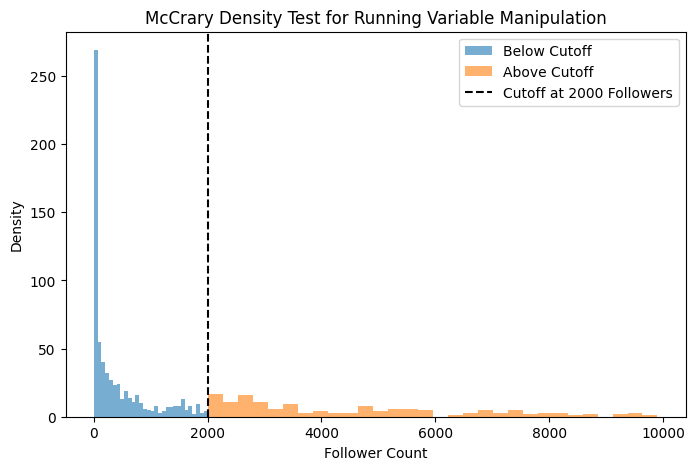

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Eligibility for Twitter subscription program
df["D"] = (df["follower_count"] >= 2000).astype(int)

# --------------- Step 1: Data Visualization ---------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["follower_count"], y=df["tweet_count"], alpha=0.5, label="Observed Tweet Count")

# Cutoff at follower count = 2000
plt.axvline(x=2000, color="black", linestyle="--", label="Cutoff at 2000 Followers")
plt.xlabel("Follower Count")
plt.ylabel("Tweet Count")
plt.title("Regression Discontinuity: Effect of Subscription Eligibility on Tweet Count")
plt.legend()
plt.show()

# --------------- Step 2: Local Linear Regression ---------------
low = df[df["follower_count"] < 2000]
high = df[df["follower_count"] >= 2000]

low_model = sm.OLS(low["tweet_count"], sm.add_constant(low["follower_count"])).fit()
high_model = sm.OLS(high["tweet_count"], sm.add_constant(high["follower_count"])).fit()

# Generate fitted values
follower_grid_low = np.linspace(0.0, 2000, 100)
follower_grid_high = np.linspace(2000, df["follower_count"].max(), 100)

Y_low_pred = low_model.predict(sm.add_constant(follower_grid_low))
Y_high_pred = high_model.predict(sm.add_constant(follower_grid_high))

# Plot fitted lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["follower_count"], y=df["tweet_count"], alpha=0.5, label="Observed Tweet Count")
plt.plot(follower_grid_low, Y_low_pred, color="blue", label="Below Cutoff (No Subscription)")
plt.plot(follower_grid_high, Y_high_pred, color="red", label="Above Cutoff (Subscription)")

# Cutoff line
plt.axvline(x=2000, color="black", linestyle="--", label="Cutoff at 2000 Followers")

# Labels and title
plt.xlabel("Follower Count")
plt.ylabel("User Engagement(Tweet Count)")
plt.title("Regression Discontinuity: Effect of Subscription Eligibility on User Engagement(Tweet Count)")
plt.legend()

# Show plot
plt.show()

# --------------- Step 3: Estimate the Causal Effect using Local Linear Regression ---------------
df["follower_centered"] = df["follower_count"] - 2000  # Center follower count at cutoff

# Interaction term for different slopes
df["D_follower"] = df["D"] * df["follower_centered"]

# Regression model
X_reg = sm.add_constant(df[["D", "follower_centered", "D_follower"]])
model = sm.OLS(df["tweet_count"], X_reg).fit()

print("\nRegression Results:")
print(model.summary())

# --------------- Step 4: Validate with Placebo Tests and Robustness Checks ---------------

# Placebo Test: Check for artificial discontinuity at follower count 1800 instead of 2000
df["D_placebo"] = (df["follower_count"] < 1800).astype(int)
X_placebo = sm.add_constant(df[["D_placebo", "follower_centered", "D_follower"]])
model_placebo = sm.OLS(df["tweet_count"], X_placebo).fit()

print("\nPlacebo Test (Cutoff at 1800 Followers):")
print(model_placebo.summary())

# McCrary's Density Test to check for manipulation of follower count near cutoff
def plot_density_test(X, cutoff=2000, bins=30):
    plt.figure(figsize=(8,5))
    plt.hist(X[X < cutoff], bins=bins, alpha=0.6, label="Below Cutoff")
    plt.hist(X[X >= cutoff], bins=bins, alpha=0.6, label="Above Cutoff")
    plt.axvline(cutoff, color='black', linestyle='--', label="Cutoff at 2000 Followers")
    plt.xlabel("Follower Count")
    plt.ylabel("Density")
    plt.title("McCrary Density Test for Running Variable Manipulation")
    plt.legend()
    plt.show()

plot_density_test(df["follower_count"])


# **Analysis of Twitter Subscription Program's Effect on Tweet Count**

## **1. Key Findings**
- **Subscription eligibility (\(D = 1\)) significantly reduces tweet count by ~4935 tweets** (p = 0.024).
- **Follower count positively affects tweet count** (+6.64 tweets per follower, p < 0.001).
- **Interaction term (\(D \times \text{follower count}\)) is negative**, meaning the positive effect of followers weakens after eligibility.

## **2. Statistical Model Overview**
- **\( R^2 = 0.156 \)**: The model explains 15.6% of tweet count variation.
- **F-statistic = 49.39, p < 0.001**: The model is statistically significant.
- **Durbin-Watson = 2.089**: No strong autocorrelation in residuals.
- **Jarque-Bera = 78837.148, p < 0.001**: Residuals deviate from normality.

## **3. Possible Explanations**
- **Reduced incentive to tweet frequently** after subscription.
- **Shift toward different engagement forms** (e.g., long threads, private messages).
- **Unobserved factors** influencing behavior (e.g., monetization strategies).

## **4. Policy Implications & Recommendations**
### **1. Adjust the Cutoff Threshold**
- **Increase the threshold (e.g., from 2000 to 5000 followers)**  
  → Ensures that only highly active users subscribe, reducing potential disengagement.  

### **2. Introduce Incentives for Continued Engagement**
- Provide **tweet-based rewards** for subscribers to maintain activity.
- Improve visibility of subscriber tweets to encourage participation.

### **3. Further Investigation Needed**
- Examine **long-term effects** of subscription on engagement.
- Identify **different user segments** to tailor the program effectively.

**Conclusion:** While subscription eligibility appears to reduce tweet count, strategic adjustments in cutoff thresholds and engagement incentives could mitigate this effect.
